In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import cvxpy as cvx
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
import random
import seaborn as sns

import sys
sys.path.append('/Users/smiskov/Documents/SLAC/PVInsight/solar-data-tools/tests/fixtures/signal_decompositions/')
from utils import plot_decomp

from solardatatools.osd_signal_decompositions import l2_l1d1_l2d2p365 as osd_sd
from solardatatools.signal_decompositions import l2_l1d1_l2d2p365 as cvx_sd

In [2]:
%load_ext autoreload
%autoreload 2

# `l2_l1d1_l2d2`

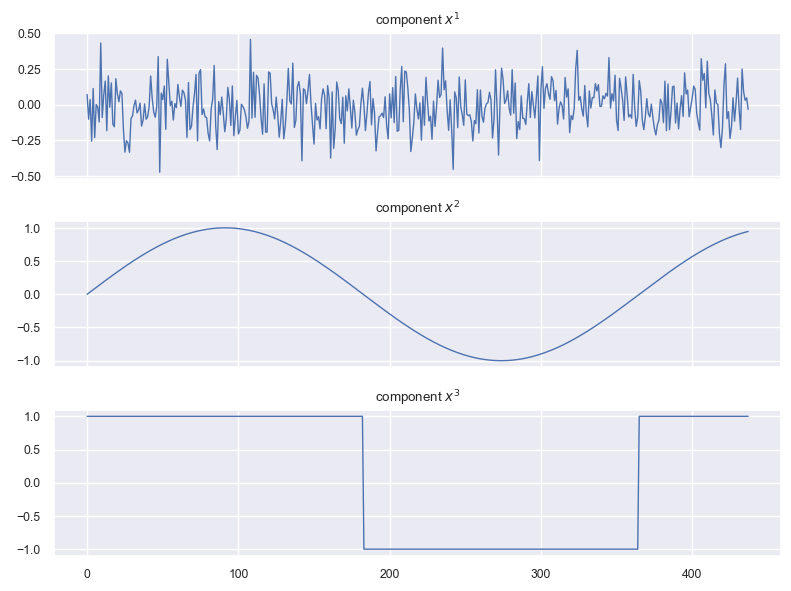

In [3]:
np.random.seed(12) 
random.seed(10)
t = np.arange(365*1.2)

signal2 = np.sin(2 * np.pi * t * 1 / (365.))  
signal3 = signal.square(2 * np.pi * t * 1 / (365.)) 
signal1 = 0.15 * np.random.randn(len(signal2))

X_real = np.zeros((3, len(t)), dtype=float)
X_real[0] = signal1
X_real[1] = signal2
X_real[2] = signal3
y = np.sum(X_real, axis=0)

plot_decomp(X_real)

Data with missing values

In [4]:
indices_full = list(range(len(X_real[1])))
# select 20% randomly
indices_20perc = np.random.choice(indices_full, int(0.2*len(y)), replace=False)

X_real_80perc = X_real.copy()
y_80perc = y.copy()

X_real_80perc[0][indices_20perc] = np.nan
X_real_80perc[1][indices_20perc] = np.nan
X_real_80perc[2][indices_20perc] = np.nan
y_80perc[indices_20perc] = np.nan

Data with missing chunks

In [5]:
indices_chunks_start = np.random.choice(indices_full, 5, replace=False)
X_real_chunks= X_real.copy()
y_chunks = y.copy()

for e in indices_chunks_start:
    for i in range(e, e+25):
        X_real_chunks[0][i] = np.nan
        X_real_chunks[1][i] = np.nan
        X_real_chunks[2][i] = np.nan
        y_chunks[i] = np.nan

# Tests

CVXPY objective       94.65700
OSD objective, scaled 94.65731
s_hat MAE  (OSD+MOSEK,CVX)   7.20e-06
s_seas MAE (OSD+MOSEK,CVX)   5.46e-06
s_hat MAE  (OSD+QSS,CVX)     4.17e-03
s_seas MAE (OSD+QSS,CVX)     4.18e-03


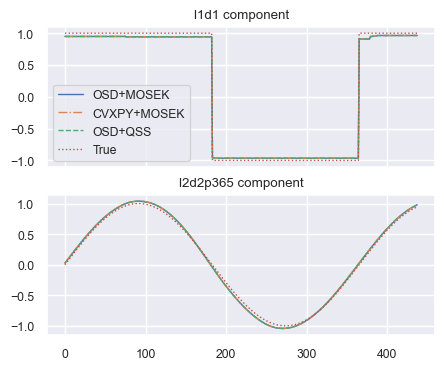

In [6]:
w_osd = { 'w0' : 5,
          'w1' : 10,
          'w2' : 4e5
          }
w_cvx = { 'c0' : 5,
          'c1' : 10,
          'c2' : 4e5
          }

osd_output = osd_sd(y, **w_osd, solver="MOSEK")
osd_qss_output = osd_sd(y, **w_osd, solver="QSS")

cvxpy_output = cvx_sd(y, **w_cvx, solver="MOSEK", comp_osd=osd_output) # for osd scaling
cvxpy_output = cvx_sd(y, **w_cvx, solver="MOSEK")

print(f's_hat MAE  (OSD+MOSEK,CVX)   {mae(osd_output[0], cvxpy_output[0]):.2e}')
print(f's_seas MAE (OSD+MOSEK,CVX)   {mae(osd_output[1], cvxpy_output[1]):.2e}')
print(f's_hat MAE  (OSD+QSS,CVX)     {mae(osd_qss_output[0], cvxpy_output[0]):.2e}')
print(f's_seas MAE (OSD+QSS,CVX)     {mae(osd_qss_output[1], cvxpy_output[1]):.2e}')


f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(5,4))
ax1.plot(osd_output[0], label="OSD+MOSEK", linewidth=1)
ax1.plot(cvxpy_output[0], label="CVXPY+MOSEK", linewidth=1, linestyle="-.")
ax1.plot(cvxpy_output[0], label="OSD+QSS", linewidth=1, linestyle="--")
# ax1.plot(y, label="Observed", linestyle=":", linewidth=1, alpha=1, color="gray")
ax1.plot(X_real[2], label="True", linestyle=":", linewidth=1, alpha=1)

ax2.plot(osd_output[1], label="OSD+MOSEK", linewidth=1)
ax2.plot(cvxpy_output[1], label="CVXPY+MOSEK", linewidth=1, linestyle="-.")
ax2.plot(cvxpy_output[1], label="OSD+QSS", linewidth=1, linestyle="--")
# ax2.plot(y, label="Observed", linestyle=":", linewidth=1, alpha=1, color="gray")
ax2.plot(X_real[1], label="True", linestyle=":", linewidth=1, alpha=1)

ax1.set_title("l1d1 component")
ax2.set_title("l2d2p365 component")
ax1.legend();
plt.savefig("l2_l1d1_l2d2p365_synt", dpi=300)

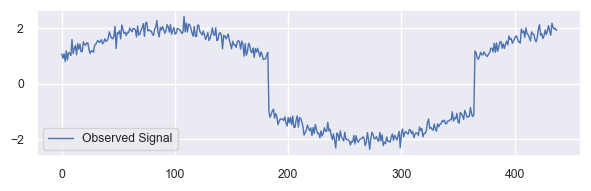

In [6]:
# plot observed
f, ax = plt.subplots(1, 1, figsize=(6,2))
ax.plot(y, linewidth=1, label="Observed Signal");
ax.legend()
plt.tight_layout()
plt.savefig("l2_l1d1_l2d2p365_synt_observed", dpi=300)

CVXPY objective       86.35754
OSD objective, scaled 86.35592
s_hat MAE  (OSD-MOSEK,CVX)   3.39e-05
s_seas MAE (OSD-MOSEK,CVX)   3.12e-05
s_hat MAE  (OSD-QSS,CVX)     6.00e-04
s_seas MAE (OSD-QSS,CVX)     5.03e-04


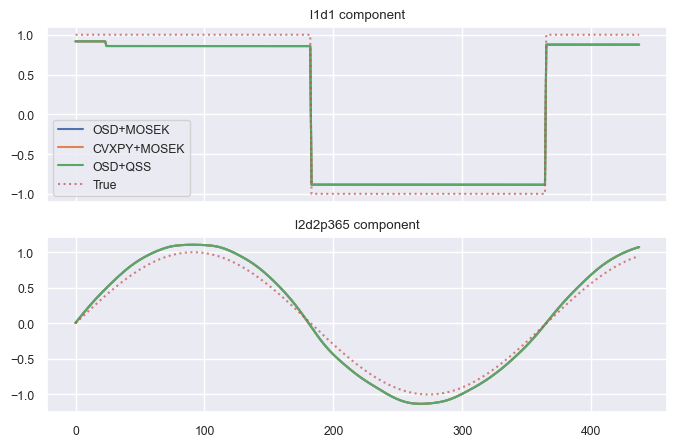

In [9]:
w_osd = { 'w0' : 5,
          'w1' : 10,
          'w2' : 5e4 # was 5e5 but takes too long
          }
w_cvx = { 'c0' : 5,
          'c1' : 10,
          'c2' : 5e4
          }

osd_output = osd_sd(y, **w_osd, solver="MOSEK")
osd_qss_output = osd_sd(y, **w_osd, solver="QSS")

cvxpy_output = cvx_sd(y, **w_cvx, solver="MOSEK", comp_osd=osd_output) # for osd scaling

cvxpy_output = cvx_sd(y, **w_cvx, solver="MOSEK")

print(f's_hat MAE  (OSD-MOSEK,CVX)   {mae(osd_output[0], cvxpy_output[0]):.2e}')
print(f's_seas MAE (OSD-MOSEK,CVX)   {mae(osd_output[1], cvxpy_output[1]):.2e}')
print(f's_hat MAE  (OSD-QSS,CVX)     {mae(osd_qss_output[0], cvxpy_output[0]):.2e}')
print(f's_seas MAE (OSD-QSS,CVX)     {mae(osd_qss_output[1], cvxpy_output[1]):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,5))
ax1.plot(osd_output[0], label="OSD+MOSEK")
ax1.plot(cvxpy_output[0], label="CVXPY+MOSEK")
ax1.plot(osd_qss_output[0], label="OSD+QSS")
ax1.plot(X_real[2], label="True", linestyle=":", alpha=0.7)
ax2.plot(osd_output[1], label="OSD+MOSEK")
ax2.plot(cvxpy_output[1], label="CVXPY+MOSEK")
ax2.plot(osd_qss_output[1], label="OSD+QSS")
ax2.plot(X_real[1], label="True", linestyle=":", alpha=0.7)
ax1.set_title("l1d1 component")
ax2.set_title("l2d2p365 component")
ax1.legend();
#plt.savefig("l2_l1d1_l2d2p365_synt")

CVXPY objective       85.90948
OSD objective, scaled 85.90953
s_hat MAE (OSD,CVX)   1.36e-05
s_seas MAE (OSD,CVX)   1.43e-05


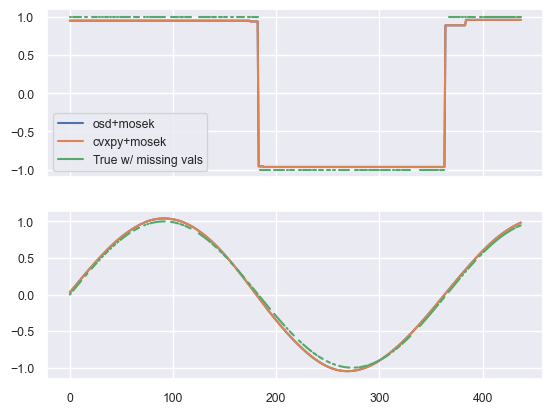

In [10]:
w_osd = { 'w0' : 5,
          'w1' : 10,
          'w2' : 5e5
          }
w_cvx = { 'c0' : 5,
          'c1' : 10,
          'c2' : 5e5
          }

osd_output = osd_sd(y_80perc, **w_osd, solver="MOSEK")
cvxpy_output = cvx_sd(y_80perc, **w_cvx, solver="MOSEK", comp_osd=osd_output) # for osd scaling

cvxpy_output = cvx_sd(y_80perc, **w_cvx, solver="MOSEK")

print(f's_hat MAE (OSD,CVX)   {mae(osd_output[0], cvxpy_output[0]):.2e}')
print(f's_seas MAE (OSD,CVX)   {mae(osd_output[1], cvxpy_output[1]):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(osd_output[0], label="osd+mosek")
ax1.plot(cvxpy_output[0], label="cvxpy+mosek")
ax1.plot(X_real_80perc[2], label="True w/ missing vals")
ax2.plot(osd_output[1], label="osd+mosek")
ax2.plot(cvxpy_output[1], label="cvxpy+mosek")
ax2.plot(X_real_80perc[1])
ax1.legend();

CVXPY objective       119.68133
OSD objective, scaled 119.68073
s_hat MAE (OSD,CVX)   1.07e-05
s_seas MAE (OSD,CVX)   1.17e-05


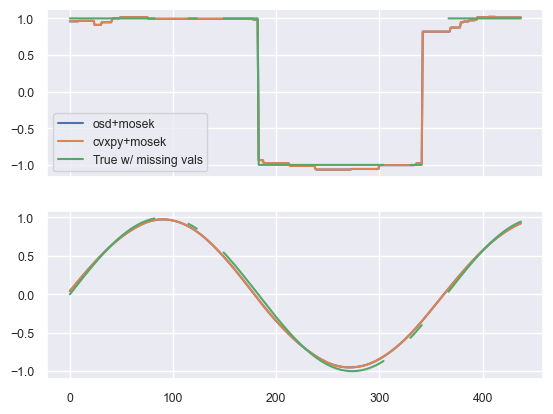

In [9]:
w_osd = { 'w0' : 10,
          'w1' : 10,
          'w2' : 5e5
          }
w_cvx = { 'c0' : 10,
          'c1' : 10,
          'c2' : 5e5
          }

osd_output = osd_sd(y_chunks, **w_osd, solver="MOSEK")
cvxpy_output = cvx_sd(y_chunks, **w_cvx, solver="MOSEK", comp_osd=osd_output) # for osd scaling

cvxpy_output = cvx_sd(y_chunks, **w_cvx, solver="MOSEK")

print(f's_hat MAE (OSD,CVX)   {mae(osd_output[0], cvxpy_output[0]):.2e}')
print(f's_seas MAE (OSD,CVX)   {mae(osd_output[1], cvxpy_output[1]):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(osd_output[0], label="osd+mosek")
ax1.plot(cvxpy_output[0], label="cvxpy+mosek")
ax1.plot(X_real_chunks[2], label="True w/ missing vals")
ax2.plot(osd_output[1], label="osd+mosek")
ax2.plot(cvxpy_output[1], label="cvxpy+mosek")
ax2.plot(X_real_chunks[1])
ax1.legend();

# SumCard (for changepoints)

CVXPY objective       133.74903
OSD objective, scaled 848.43806
s_hat MAE  (OSD-QSS,CVX)     7.40e-01
s_seas MAE (OSD-QSS,CVX)     7.33e-01


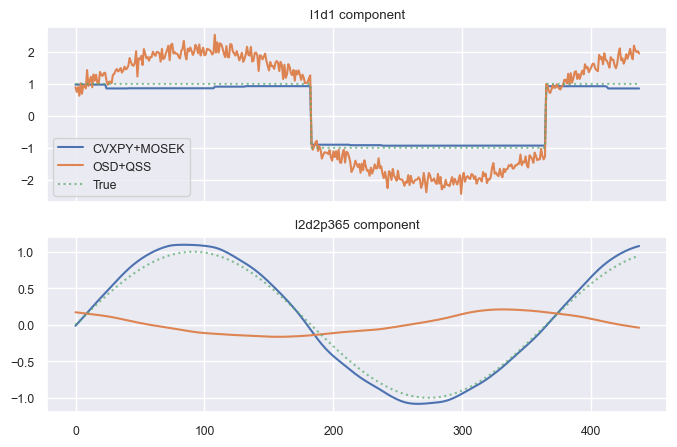

In [10]:

w_osd = { 'w0' : 10,
          'w1' : 0.003,
          'w2' : 1e3
          }
w_cvx = { 'c0' : 10,
          'c1' : 10,
          'c2' : 5e4
          }

osd_qss_output = osd_sd(y, **w_osd, solver="QSS", sum_card=True)

cvxpy_output = cvx_sd(y, **w_cvx, solver="MOSEK", comp_osd=osd_qss_output) # for osd scaling

cvxpy_output = cvx_sd(y, **w_cvx, solver="MOSEK")

print(f's_hat MAE  (OSD-QSS,CVX)     {mae(osd_qss_output[0], cvxpy_output[0]):.2e}')
print(f's_seas MAE (OSD-QSS,CVX)     {mae(osd_qss_output[1], cvxpy_output[1]):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,5))
ax1.plot(cvxpy_output[0], label="CVXPY+MOSEK")
ax1.plot(osd_qss_output[0], label="OSD+QSS")
ax1.plot(X_real[2], label="True", linestyle=":", alpha=0.7)
ax2.plot(cvxpy_output[1], label="CVXPY+MOSEK")
ax2.plot(osd_qss_output[1], label="OSD+QSS")
ax2.plot(X_real[1], label="True", linestyle=":", alpha=0.7)
ax1.set_title("l1d1 component")
ax2.set_title("l2d2p365 component")
ax1.legend();


In [63]:
results = {}

weight_hat_iter = np.logspace(-0.6, 1.3, 10)
weight_seas_iter = np.logspace(3.5, 5.5, 10)


def run(sig):
    
    min_w_seas, min_w_shat = 1, 1
    rmse_s_seas_list, mae_s_hat_list = [], []
    w_shat_min, w_seas_min = 0, 0
    
    for i, w1 in tqdm(enumerate(weight_hat_iter)):
        mae_list, mse_list = [], []
        for j, w2 in enumerate(weight_seas_iter):
            s_hat_ss, s_seas_ss = osd_sd(sig, w0=10, w1=w1, w2=w2, solver="QSS", sum_card=True)
            a = mae(cvxpy_output[1], s_seas_ss)
            b = mae(cvxpy_output[0], s_hat_ss)
            mse_list.append(a)
            mae_list.append(b)
            if a<=min_w_seas and b<=min_w_shat:
                min_w_seas = a
                min_w_shat = b
                w_shat_min, w_seas_min = w1, w2
                print(w1, w2)
        mae_s_hat_list.append(mae_list)
        rmse_s_seas_list.append(mse_list)
        
    results["mae_s_hat_list"] = mae_s_hat_list
    results["rmse_s_seas_list"] = rmse_s_seas_list
    results["min_shat_seas"] = (w_shat_min, w_seas_min)

In [64]:
run(y)

0it [00:00, ?it/s]

0.251188643150958 5274.99706370262


1it [00:59, 59.34s/it]

0.40842386526745217 3162.2776601683795


6it [05:56, 59.75s/it]

4.641588833612778 14677.992676220705


10it [09:28, 56.88s/it]


In [65]:
print(results["min_shat_seas"])

(4.641588833612778, 14677.992676220705)


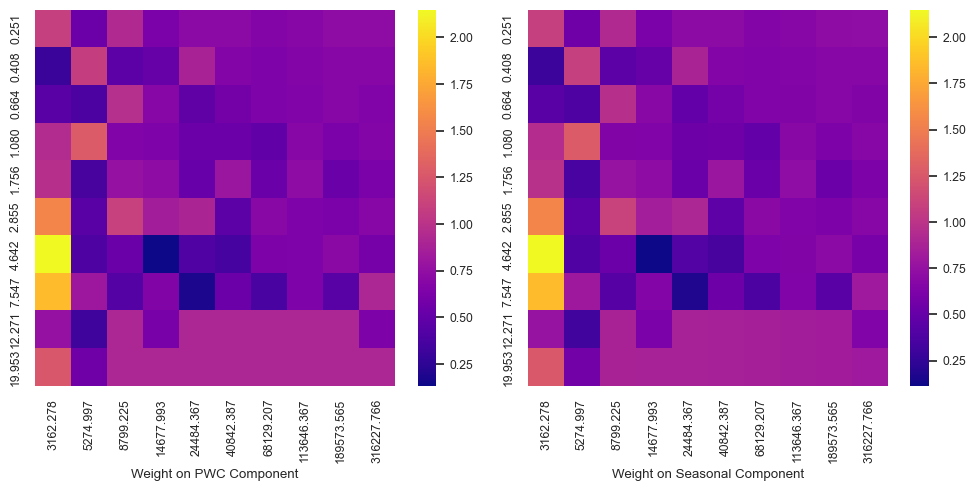

In [66]:
f, ax = plt.subplots(1,2, sharex=True, figsize=(10,5))

x_axis_labels = ['{:.3f}'.format(x) for x in weight_seas_iter]
y_axis_labels = ['{:.3f}'.format(x) for x in weight_hat_iter]

m = results["mae_s_hat_list"]
s = sns.heatmap(m, cmap="plasma", ax=ax[0], xticklabels=x_axis_labels, yticklabels=y_axis_labels)
s.set(xlabel='Weight on PWC Component')

m = results["rmse_s_seas_list"]
s = sns.heatmap(m, cmap="plasma", ax=ax[1], xticklabels=x_axis_labels, yticklabels=y_axis_labels)
s.set(xlabel='Weight on Seasonal Component')

plt.tight_layout()
plt.show()

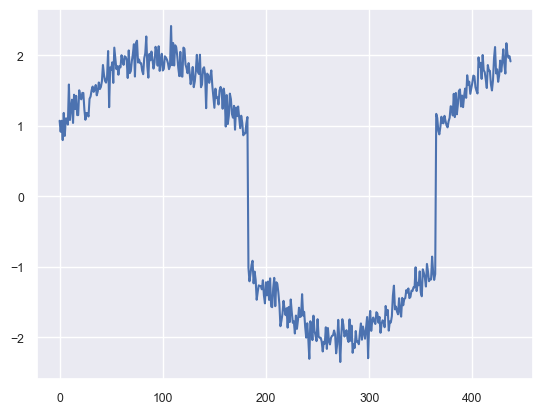

In [74]:
plt.plot(y);

In [90]:
from gfosd import Problem
import gfosd.components as comp

c1 = comp.SumSquare(weight=1/len(y))
c2 = comp.SumCard(weight=1/len(y-1), diff=1)
c3 = comp.Aggregate([
    comp.SumSquare(weight=1e2, diff=2),
    comp.Periodic(period=365),
    comp.AverageEqual(0, period=365)
])
foo = Problem(y, [c1, c2, c3])
foo.decompose(verbose=True)

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
initial factorization time:      3.26e-03s
(nonconvex warm-start algorithm)

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 9.04e-01    9.66e-01     2.15e-01   [0.1 0.1]  5.48e-04
   25 | 1.01e-01    2.49e-03     1.19e-03   [0.1 0.1]  1.07e-02
   50 | 3.61e-02    1.64e-02     3.41e-02   [1.e-01 1.e-06]  2.26e-02
   75 | 3.26e-02    9.87e-05     4.24e-04   [1.e-01 1.e-06]  3.25e-02
  100 | 3.25e-02    3.44e-05     1.80e-04   [1.e-01 1.e-06]  4.26e-02
  125 | 3.25e-02    1.36e-05     8.94e-05   [1.e-01 1.e-06]  5.20e-02
  1

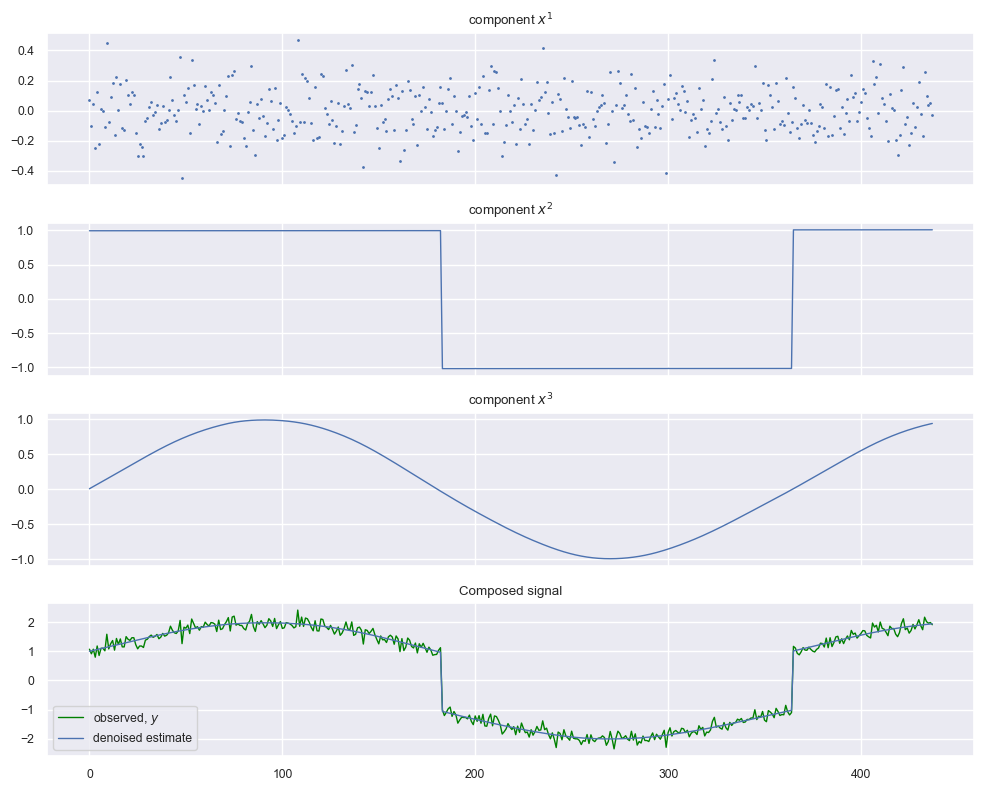

In [91]:
foo.plot_decomposition();

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
initial factorization time:      5.28e-03s
(nonconvex warm-start algorithm)

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 8.78e-01    9.66e-01     1.08e-01   [0.1 0.1]  5.20e-04
   25 | 1.01e-01    3.27e-03     1.20e-03   [0.1 0.1]  1.00e-02
   50 | 3.56e-02    3.48e-02     5.46e-03   [1.e-01 1.e-06]  2.31e-02
   75 | 3.30e-02    9.73e-04     3.57e-04   [1.e-01 1.e-06]  3.31e-02
  100 | 3.29e-02    7.25e-04     1.30e-04   [1.e-01 1.e-06]  4.23e-02
  125 | 3.29e-02    1.17e-05     1.00e-05   [1.e-01 1.e-06]  5.08e-02
  1

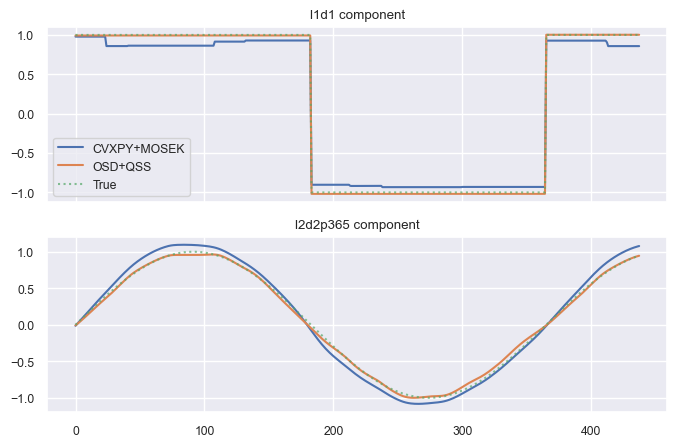

In [72]:
w_osd = { 'w0' : 1/len(y),
          'w1' : 3e-3,
          'w2' : 5,
          }

w_cvx = { 'c0' : 10,
          'c1' : 10,
          'c2' : 5e4
          }

osd_qss_output = osd_sd(y, **w_osd, solver="QSS", sum_card=True, verbose=True)

cvxpy_output = cvx_sd(y, **w_cvx, solver="MOSEK", comp_osd=osd_qss_output) # for osd scaling

cvxpy_output = cvx_sd(y, **w_cvx, solver="MOSEK")

print(f's_hat MAE  (OSD-QSS,CVX)     {mae(osd_qss_output[0], cvxpy_output[0]):.2e}')
print(f's_seas MAE (OSD-QSS,CVX)     {mae(osd_qss_output[1], cvxpy_output[1]):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,5))
ax1.plot(cvxpy_output[0], label="CVXPY+MOSEK")
ax1.plot(osd_qss_output[0], label="OSD+QSS")
ax1.plot(X_real[2], label="True", linestyle=":", alpha=0.7)
ax2.plot(cvxpy_output[1], label="CVXPY+MOSEK")
ax2.plot(osd_qss_output[1], label="OSD+QSS")
ax2.plot(X_real[1], label="True", linestyle=":", alpha=0.7)
ax1.set_title("l1d1 component")
ax2.set_title("l2d2p365 component")
ax1.legend();

---------------------------------------------------------------
              QSS: the Quadratic-Separable Solver              
                     author: Luke Volpatti                     
---------------------------------------------------------------
initial factorization time:      2.88e-03s
(nonconvex warm-start algorithm)

                           ADMM solve                          
---------------------------------------------------------------
 iter | objective | primal res | dual res |   rho   | time (s) 
---------------------------------------------------------------
    1 | 9.04e-01    9.66e-01     2.15e-01   [0.1 0.1]  5.33e-04
   25 | 1.01e-01    2.48e-03     1.19e-03   [0.1 0.1]  1.03e-02
   50 | 3.61e-02    1.63e-02     3.42e-02   [1.e-01 1.e-06]  2.20e-02
   75 | 3.26e-02    9.86e-05     4.24e-04   [1.e-01 1.e-06]  3.24e-02
  100 | 3.25e-02    3.44e-05     1.80e-04   [1.e-01 1.e-06]  4.33e-02
  125 | 3.25e-02    1.37e-05     8.94e-05   [1.e-01 1.e-06]  5.37e-02
  1

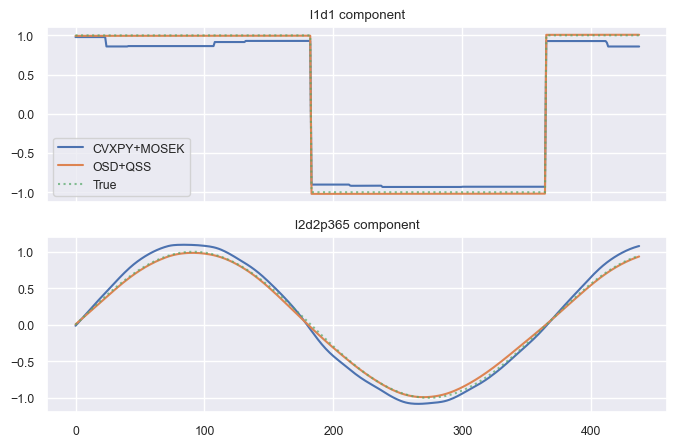

In [15]:
w_osd = { 'w0' : 1/len(y),
          'w1' : 1/(len(y)-1),
          'w2' : 100,
          }

w_cvx = { 'c0' : 10,
          'c1' : 10,
          'c2' : 5e4
          }

osd_qss_output = osd_sd(y, **w_osd, solver="QSS", sum_card=True, verbose=True)

cvxpy_output = cvx_sd(y, **w_cvx, solver="MOSEK", comp_osd=osd_qss_output) # for osd scaling

cvxpy_output = cvx_sd(y, **w_cvx, solver="MOSEK")

print(f's_hat MAE  (OSD-QSS,CVX)     {mae(osd_qss_output[0], cvxpy_output[0]):.2e}')
print(f's_seas MAE (OSD-QSS,CVX)     {mae(osd_qss_output[1], cvxpy_output[1]):.2e}')

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8,5))
ax1.plot(cvxpy_output[0], label="CVXPY+MOSEK")
ax1.plot(osd_qss_output[0], label="OSD+QSS")
ax1.plot(X_real[2], label="True", linestyle=":", alpha=0.7)
ax2.plot(cvxpy_output[1], label="CVXPY+MOSEK")
ax2.plot(osd_qss_output[1], label="OSD+QSS")
ax2.plot(X_real[1], label="True", linestyle=":", alpha=0.7)
ax1.set_title("l1d1 component")
ax2.set_title("l2d2p365 component")
ax1.legend();